# CatBoost Classifier

In [23]:
# Import Libraries

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

pd.options.display.max_columns = 20

In [24]:
df = pd.read_csv('Exported Data/DF_from_Feature_Sel_for_Model_Sel.csv')

## Preparing data and preprocessor to be used in pipeline

In [25]:
# Define dataset and target variable
X = df.drop('Delayed', axis=1)  # Features (all columns except 'Delayed')
y = df['Delayed']               # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)  

# Categorical columns for one-hot encoding
cat_cols = ['Carrier_Name', 'Month', 'Week_Day', 'Origin', 'Destination', 'Dep_Time_Block_Group', 'Arr_Time_Block_Group']

# Numerical columns for standard scaling 
num_cols = ['Distance_Group', 'Distance_Miles', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time']

# Preprocessing pipeline with handling of unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),                                   # Numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols) # Categorical features
    ], remainder='passthrough')

## CatBoost Model Creation

In [26]:
# Define the full pipeline including classifier
clf_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=1, verbose=0))
])

# Fit the pipeline on training data
clf_cb.fit(X_train, y_train)

# Predictions on test data
y_pred_cb = clf_cb.predict(X_test)


## Initial Model Performance

In [27]:
# Calculate confusion matrix
cm_init = confusion_matrix(y_test, y_pred_cb)

# Calculate precision and recall
precision_init, recall_init, _ = precision_recall_curve(y_test, y_pred_cb)

# Calculate ROC curve
fpr_init, tpr_init, _ = roc_curve(y_test, y_pred_cb)

# Calculate ROC AUC score
roc_auc_init = roc_auc_score(y_test, y_pred_cb)

# Calculate evaluation metrics
accuracy_init = accuracy_score(y_test, y_pred_cb)
f1_init= f1_score(y_test, y_pred_cb)

Confusion Matrix:
 [[182898  91814]
 [ 96392 177477]]
Accuracy: 0.6569221318273873
F1 Score: 0.6534980484571765
ROC AUC Score: 0.6569084976928404
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66    274712
           1       0.66      0.65      0.65    273869

    accuracy                           0.66    548581
   macro avg       0.66      0.66      0.66    548581
weighted avg       0.66      0.66      0.66    548581



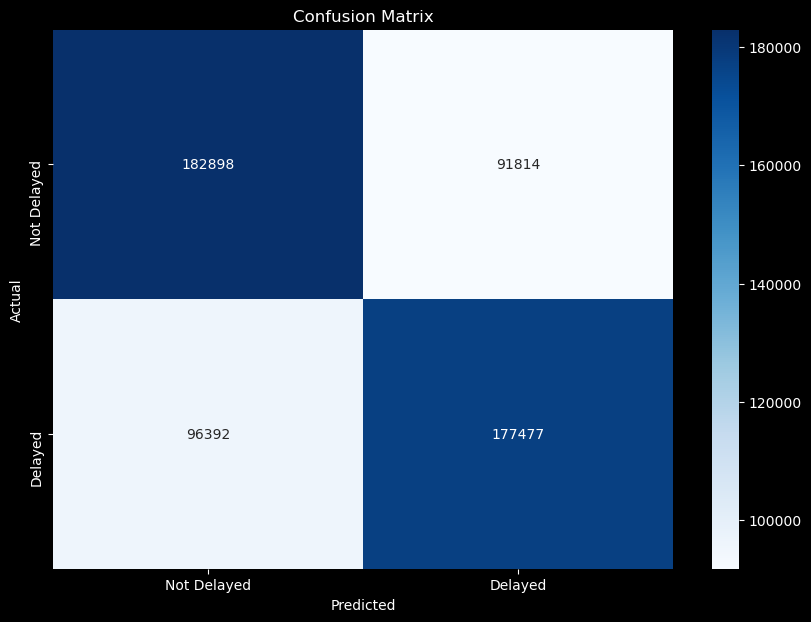

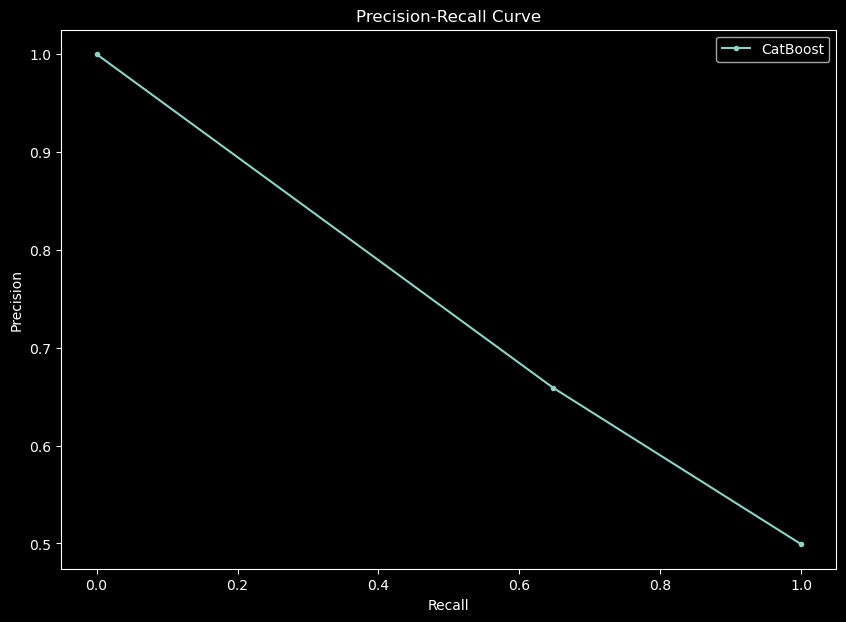

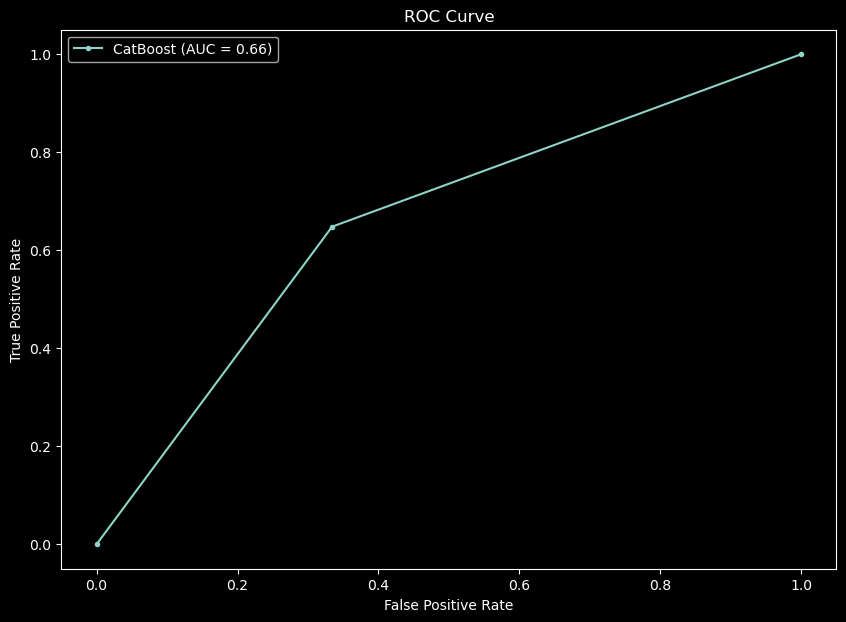

In [ ]:
# Display metrics
print("Confusion Matrix:\n", cm_init)
print("Accuracy:", accuracy_init)
print("F1 Score:", f1_init)
print("ROC AUC Score:", roc_auc_init)
print("Classification Report:\n", classification_report(y_test, y_pred_cb))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall_init, precision_init, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_init, tpr_init, marker='.', label='CatBoost (AUC = %0.2f)' % roc_auc_init)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Summary

- #### The model has an accuracy of about **65.69%**, meaning it correctly classifies approximately **66%** of the instances.
- #### The F1 score, which balances precision and recall, is approximately **65.35%**, indicating a moderate performance.
- #### The ROC AUC score is about **65.69%**, suggesting that the model is somewhat capable of distinguishing between the two classes, but there's room for improvement.
- #### The classification report indicates similar performance for both classes, with precision, recall, and F1 scores around **65-67%**.

#### Overall, while the model shows some ability to classify the data, its performance metrics suggest that there is considerable room for improvement.


## k-Folds Cross Validation

In [29]:
# Defining k-Folds Cross Validation parameters
accuracies = cross_val_score(estimator = clf_cb,
                    X = X,
                    y = y,
                    scoring = 'accuracy',
                    cv = 10)

print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f}".format(accuracies.std()))

/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 65.722 %
Standard Deviation: 0.001


## k-Folds Cross Validation Summary

#### **Accuracy**: The accuracy of 65.722% suggests that your model is correctly predicting the target variable approximately 65.7% of the time. This accuracy will serve as a baseline to gauge improvement after hyperparameter tuning.

#### **Standard Deviation**: The standard deviation of 0.001 (or 0.1%) indicates that the accuracy across different folds is very consistent, suggesting that your model's performance is stable across the dataset splits.


## Hyperparameter Tuning

In [32]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'classifier__learning_rate': [0.001, 0.005, 0.01],
    'classifier__depth': [4, 7, 10],
    'classifier__l2_leaf_reg': [2, 6, 10],
    'classifier__random_strength': [0, 5, 10]
}

grid_search = GridSearchCV(estimator=clf_cb,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=10)

grid_search.fit(X, y)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.3f} %".format(best_accuracy * 100))
print("Best Parameters:", best_parameters)


/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warning

Best Accuracy: 64.231 %
Best Parameters: {'classifier__depth': 10, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.01, 'classifier__random_strength': 0}


## Tuned CatBoost Model Creation

In [39]:
# Define the full pipeline including classifier
cb_opt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(depth=10, 
                                    l2_leaf_reg=2, 
                                    learning_rate=0.01,
                                    random_strength=0, 
                                    random_state=1, 
                                    verbose=0)) # Specified Hyperparameters
])

# Fit the pipeline on training data
cb_opt_model.fit(X_train, y_train)

# Predictions on test data
y_pred_cb_opt = cb_opt_model.predict(X_test)

## Model Performance after Hyperparameter Tuning

In [40]:
# Calculate confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_cb_opt)

# Calculate precision and recall
precision_opt, recall_opt, _ = precision_recall_curve(y_test, y_pred_cb_opt)

# Calculate ROC curve
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_cb_opt)

# Calculate ROC AUC score
roc_auc_opt = roc_auc_score(y_test, y_pred_cb_opt)

# Calculate evaluation metrics
accuracy_opt = accuracy_score(y_test, y_pred_cb_opt)
f1_opt= f1_score(y_test, y_pred_cb_opt)

Confusion Matrix:
 [[178711  96001]
 [ 99975 173894]]
Accuracy: 0.6427583164564576
F1 Score: 0.639593647244025
ROC AUC Score: 0.642746340811412
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65    274712
           1       0.64      0.63      0.64    273869

    accuracy                           0.64    548581
   macro avg       0.64      0.64      0.64    548581
weighted avg       0.64      0.64      0.64    548581



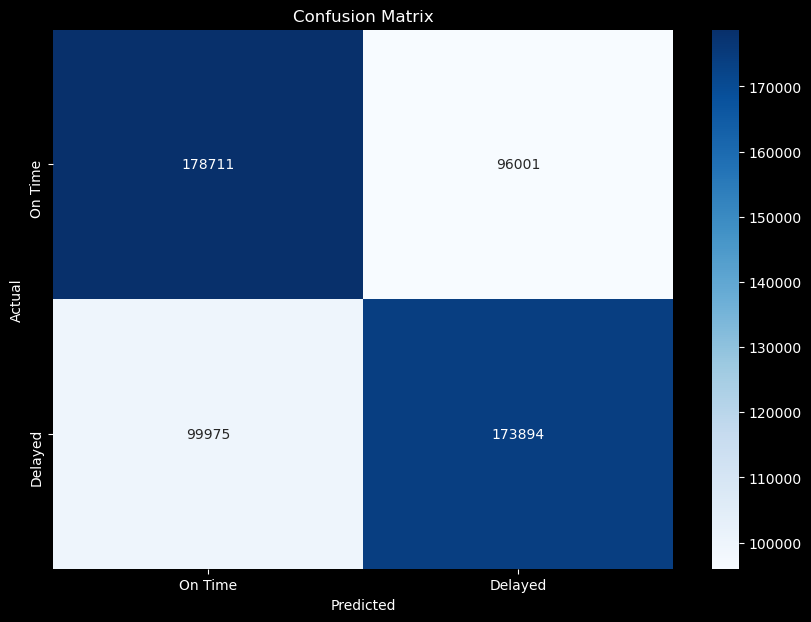

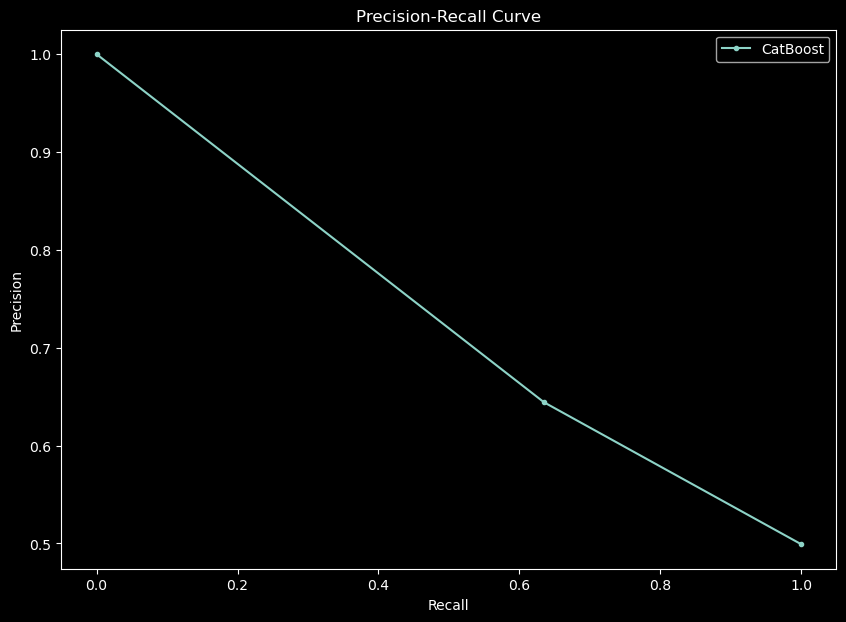

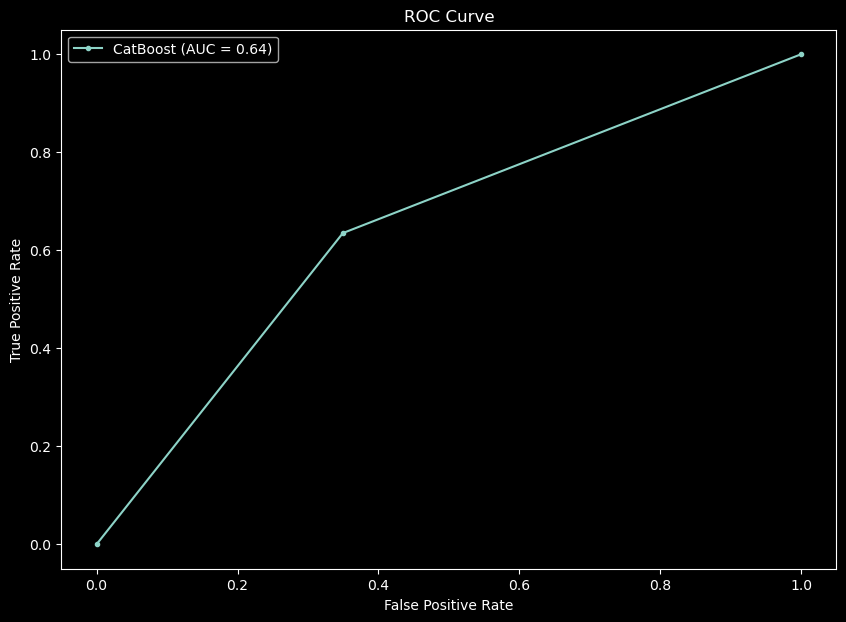

In [41]:
# Display metrics
print("Confusion Matrix:\n", cm_opt)
print("Accuracy:", accuracy_opt)
print("F1 Score:", f1_opt)
print("ROC AUC Score:", roc_auc_opt)
print("Classification Report:\n", classification_report(y_test, y_pred_cb_opt))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall_opt, precision_opt, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_opt, tpr_opt, marker='.', label='CatBoost (AUC = %0.2f)' % roc_auc_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## k-Folds Cross Validation of Model after Hyperparameter Tuning

In [42]:
# Defining k-Folds Cross Validation parameters
accuracies = cross_val_score(estimator = cb_opt_model,
                    X = X,
                    y = y,
                    scoring = 'accuracy',
                    cv = 10)

print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f}".format(accuracies.std()))

/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/briantreftz/miniconda3/envs/FS_Env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 64.231 %
Standard Deviation: 0.001
